# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2026

### Case study: Metal ion concentration prediction (video lectures, slides and scripts in MOOC2) 

## Import libraries

In [141]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import somersd

## Read and visualize the dataset

In [225]:
data = pd.read_csv('water_data.csv')
data.head() # first five rows

,Mod1,Mod2,Mod3,c_total,Cd,Pb
0,-0.994673,-0.662192,0.327797,14.0,2.8,11.2
1,-0.982196,-0.662465,0.976950,14.0,0.0,14.0
2,2.063228,2.552820,1.681019,200.0,200.0,0.0
3,-0.839376,-0.586206,-1.471322,5000.0,3000.0,2000.0
4,-0.846858,-0.543135,-1.404644,5000.0,4000.0,1000.0


In [226]:
data.info() # dataset is 243 rows x 6 cols, no missing values all cols type: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mod1     243 non-null    float64
 1   Mod2     243 non-null    float64
 2   Mod3     243 non-null    float64
 3   c_total  243 non-null    float64
 4   Cd       243 non-null    float64
 5   Pb       243 non-null    float64
dtypes: float64(6)
memory usage: 11.5 KB


Outputs for the dataset are: concentration of Cadmium (cd), concentration of lead (pb) and total concentration (c_total)
Inputs are Mod1, Mod2, Mod3

Mixtures:

In [227]:
replica_counts = (
    data
    .groupby(['Cd', 'Pb'])
    .size()
    .reset_index(name='n_replicas')
)


mixtures_3 = replica_counts[replica_counts['n_replicas'] == 3]

mixtures_4 = replica_counts[replica_counts['n_replicas'] == 4]



In [228]:
print('3 mixtures:',len(mixtures_3))
print('4 mixtures:',len(mixtures_4))

3 mixtures: 25
4 mixtures: 42


In [229]:
inputs = ['Mod1', 'Mod2', 'Mod3']
X = pd.DataFrame(data, columns=inputs) # features

outputs = ['Cd', 'Pb']
Y = pd.DataFrame(data, columns=outputs)
X.head()

,Mod1,Mod2,Mod3
0,-0.994673,-0.662192,0.327797
1,-0.982196,-0.662465,0.976950
2,2.063228,2.552820,1.681019
3,-0.839376,-0.586206,-1.471322
4,-0.846858,-0.543135,-1.404644


## C-index code 

In [230]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

In [231]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

np.random.seed(42)

## Leave-One-Out cross-validation

In [242]:
# Here add your code for Leave-One-Out cross-validation and print the corresponding results.

y_true_all = []
y_pred_all = []


def LOOCV(k):
    
    for i in range(243):
        X_train = X.drop(i)
        X_test = X.loc[[i]]
    
        y_train = Y.drop(i)
        y_test = Y.loc[i]
    
        model = KNeighborsRegressor(k)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)[0]
    
        y_pred_all.append(y_pred)
    
    
        y_true_all.append(y_test)
        
    
    y_true_Cd = [y["Cd"] for y in y_true_all] # pandas df
    y_pred_Cd = [y[0] for y in y_pred_all] # numpy array
    
    y_true_Pb = [y["Pb"] for y in y_true_all]
    y_pred_Pb = [y[1] for y in y_pred_all]

    y_true_total = [y["Cd"] + y["Pb"] for y in y_true_all]
    y_pred_total = [y[0] + y[1] for y in y_pred_all]
    
    return (
        cindex(y_true_Cd, y_pred_Cd),
        cindex(y_true_Pb, y_pred_Pb),
        cindex(y_true_total, y_pred_total),
    )



In [243]:
K = [1, 3, 5, 7]

loo_cd = []
loo_pb = []
loo_total = []

for k in K:
    cindex_Cd, cindex_Pb, cindex_total = LOOCV(k)

    loo_cd.append(cindex_Cd)
    loo_pb.append(cindex_Pb)
    loo_total.append(cindex_total)
    

    print("k:",k,"c-index Cd:", cindex_Cd)
    print("k:",k,"c-index Pb:", cindex_Pb)
    print("k:",k,"c-index total:", cindex_total)
    

k: 1 c-index Cd: 0.9193779048981051
k: 1 c-index Pb: 0.8835836335747156
k: 1 c-index total: 0.9121835148901365
k: 3 c-index Cd: 0.9111235252055774
k: 3 c-index Pb: 0.8796284735847038
k: 3 c-index total: 0.912541361490129
k: 5 c-index Cd: 0.893294402733087
k: 5 c-index Pb: 0.8694158075601375
k: 5 c-index total: 0.9053963060729615
k: 7 c-index Cd: 0.876828968537719
k: 7 c-index Pb: 0.8599217886062854
k: 7 c-index total: 0.8987898278618434


The c-index calculated for Pb and Cd are very inflated due to data-leakage caused by the original dataset consisting of 25 3-replicates and 42 4-replicates of Cd and Pb, which then in LOOCV will cause these replicates to be in the training and testing at the same time

Thus as stated in the slides, the assumption of independence is violated, resulting in overly optimistic results

## Leave-Replicas-Out cross-validation

In [244]:
n_groups = len(mixtures_3) + len(mixtures_4)
print("amount of groups formed by 3 & 4 replicates:", n_groups)

amount of groups formed by 3 & 4 replicates: 67


In [245]:
print(Y[5:10])
print(mixtures_4[0:10])

       Cd     Pb
5   500.0    0.0
6  1600.0  400.0
7   160.0   40.0
8    14.0    0.0
9     0.0  100.0
      Cd      Pb  n_replicas
1    0.0    14.0           4
3    0.0    35.0           4
7    0.0   200.0           4
8    0.0   500.0           4
9    0.0  1000.0           4
10   0.0  2000.0           4
12   2.8    11.2           4
13   4.0    16.0           4
15   7.0    28.0           4
18  10.0    40.0           4


In [246]:
# Here add your code for Leave-Replicas-Out cross-validation and print the corresponding results.

data['group'] = data.groupby(['Cd','Pb']).ngroup()  

def LROCV(k):

    y_true_Cd, y_true_Pb = [], []
    y_pred_Cd, y_pred_Pb = [], []

    for g in data['group'].unique():

        test_idx  = data.index[data['group'] == g]
        train_idx = data.index[data['group'] != g]

        X_train = X.loc[train_idx]
        X_test  = X.loc[test_idx]

        y_train = Y.loc[train_idx]
        y_test  = Y.loc[test_idx]

        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        for i in range(len(test_idx)):
            y_true_Cd.append(y_test.iloc[i]["Cd"])
            y_true_Pb.append(y_test.iloc[i]["Pb"])

            y_pred_Cd.append(y_pred[i, 0])
            y_pred_Pb.append(y_pred[i, 1])

    y_true_total = np.array(y_true_Cd) + np.array(y_true_Pb)
    y_pred_total = np.array(y_pred_Cd) + np.array(y_pred_Pb)

    return (
        cindex(y_true_Cd, y_pred_Cd),
        cindex(y_true_Pb, y_pred_Pb),
        cindex(y_true_total, y_pred_total),
    )
    


    

In [247]:
K = [1, 3, 5, 7]

lro_cd = []
lro_pb = []
lro_total = []

for k in K:
    cindex_Cd, cindex_Pb, cindex_total = LROCV(k)

    lro_cd.append(cindex_Cd)
    lro_pb.append(cindex_Pb)
    lro_total.append(cindex_total)
    

    print("k:",k,"c-index Cd:", cindex_Cd)
    print("k:",k,"c-index Pb:", cindex_Pb)
    print("k:",k,"c-index total:", cindex_total)

k: 1 c-index Cd: 0.7553450125134072
k: 1 c-index Pb: 0.7534156173081725
k: 1 c-index total: 0.8217645090530543
k: 3 c-index Cd: 0.7592599213442974
k: 3 c-index Pb: 0.7550743766275461
k: 3 c-index total: 0.8100159869130386
k: 5 c-index Cd: 0.742652842331069
k: 5 c-index Pb: 0.7464238575964042
k: 5 c-index total: 0.8133620849908911
k: 7 c-index Cd: 0.7411691097604576
k: 7 c-index Pb: 0.7483323226197696
k: 7 c-index total: 0.815704353645388


## Compare Leave-One-Out and Leave-Replicas-Out Results

Plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

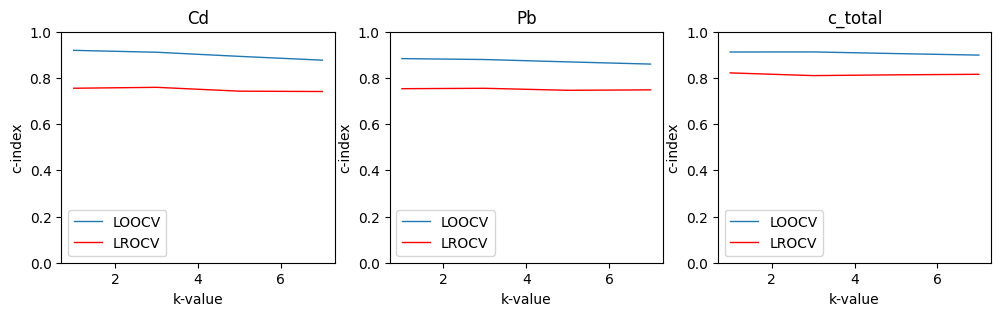

In [267]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))


sns.lineplot(
    ax=axes[0],
    x=K,
    y=loo_cd, 
    linewidth=1,
    label="LOOCV"
)

sns.lineplot(
    ax=axes[1],
    x=K,
    y=loo_pb,
    linewidth=1,
    label="LOOCV"
)

axes[0].set_title("Cd")

sns.lineplot(
    ax=axes[2],
    x=K,
    y=loo_total,
    linewidth=1,
    label="LOOCV"
)

sns.lineplot(
    ax=axes[0],
    x=K,
    y=lro_cd, 
    linewidth=1,
    color="red",
    label="LROCV"
)

axes[1].set_title("Pb")

sns.lineplot(
    ax=axes[1],
    x=K,
    y=lro_pb, 
    linewidth=1,
    color="red",
    label="LROCV"
)

sns.lineplot(
    ax=axes[2],
    x=K,
    y=lro_total, 
    linewidth=1,
    color="red",
    label="LROCV"
)


axes[2].set_title("c_total")
for ax in axes:
    ax.set_ylim(0, 1)
    ax.set_xlabel("k-value")
    ax.set_ylabel("c-index")

plt.show()

## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:

1.
LOOCV produced a much more optimistic result (~0.9 c-index / AUC) for the models performance mainly due to data leakage. With a dataset containing non-independent observations with replicates (3 & 4) the validation is basically done on 'seen' data

2.
LROCV on the other hand is a much more solid estimate of the models performance, as emitting the whole set of replicates of an instance ensures that the model will not be tested on 'seen' data during cross-validation. LROCV still returns quite strong results (~0.8 c-index / AUC) but we can be quite sure that on unseen mixtures this method much better represents the real performance of the model.

